In [49]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
import matplotlib.pyplot as plt

In [50]:
list_var = ['authorized_flag','proba_1']

In [51]:
# Read recipe inputs
transactions_known_scored = dataiku.Dataset("transactions_known_scored").get_dataframe(limit=1000)
transactions_known_scored.set_index('transaction_id', inplace=True)

In [52]:
transactions_known_scored = transactions_known_scored[list_var]
transactions_known_scored['decile'] = pd.cut(x=transactions_known_scored.proba_1, 
                                             bins=10, precision=1, right=False)

In [55]:
col_names = {'authorized_flag':'sum_true', 'proba_1':'count_pred'}
df_by_deciles = transactions_known_scored.groupby(by='decile').agg({'authorized_flag':'sum', 
                                                                    'proba_1':'count'}).rename(columns=col_names)

In [68]:
df_by_deciles['validation_ratio'] = df_by_deciles.sum_true/df_by_deciles.count_pred
df_by_deciles.sort_values(by)

,sum_true,count_pred,validation_ratio
decile,,,
"[0.03, 0.1)",0,5,0.000000
"[0.1, 0.2)",1,2,0.500000
"[0.2, 0.3)",17,27,0.629630
"[0.3, 0.4)",106,141,0.751773
"[0.4, 0.5)",291,330,0.881818
"[0.5, 0.6)",65,70,0.928571
"[0.6, 0.7)",79,84,0.940476
"[0.7, 0.8)",104,105,0.990476
"[0.8, 0.9)",109,109,1.000000


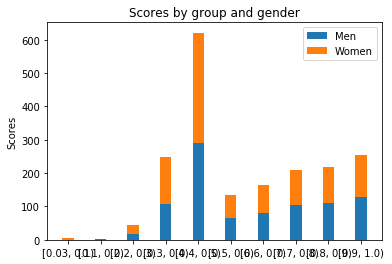

In [67]:
%matplotlib inline   

labels = list(df_by_deciles.index.astype(str))
labels.sort()
men_means = list(df_by_deciles.sum_true)
women_means = list(df_by_deciles.count_pred)
width = 0.35 # the width of the bars

fig, ax = plt.subplots()
ax.bar(labels, men_means, width, label='Men')
ax.bar(labels, women_means, width, bottom=men_means, label='Women')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()

In [0]:
# Write recipe outputs
data_viz = dataiku.Folder("ofSVU3Pe")
data_viz_info = data_viz.get_info()